In [1]:
from project_fraud.lib import drop_many_missing_values
from project_fraud.feature_engineering import clean_mail, make_day_feature, make_hour_feature, string_card, credit_cards, dist_from_mean, dist_from_median_rel


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

In [2]:
# transform_raw_data

In [3]:
def transform_raw_data():
    data = drop_many_missing_values()
    data['P_emaildomain_bin'], data['P_emaildomain_suffix'] = clean_mail(data)
    data['weekday'] = make_day_feature(data, offset=0.58)
    data['hours'] = make_hour_feature(data)
    data['cardID'] = data.apply(lambda row: string_card(row), axis=1)
    data = data.merge(credit_cards(data), how='left', on="cardID")
    data['dist_mean'] = data.apply(lambda row: dist_from_mean(row, 'mean'), axis=1)
    data['dist_median'] = data.apply(lambda row: dist_from_mean(row, 'median'), axis=1)
    data['dist_mean_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'mean'), axis=1)
    data['dist_median_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'median'), axis=1)
    return data

In [4]:
data_transformed = transform_raw_data()

In [5]:
data_transformed.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,hours,cardID,mean,min,max,median,dist_mean,dist_median,dist_mean_rel,dist_median_rel
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,2755404.0150.0mastercard102.0credit,235.020796,10.00,6085.23,115.00,-206.020796,-86.00,-0.876607,-0.747826
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,4663490.0150.0visa166.0debit,96.791005,12.50,994.00,59.00,-37.791005,0.00,-0.390439,0.000000
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.0,18132567.0150.0mastercard117.0debit,123.308485,6.00,3190.00,59.95,-73.308485,-9.95,-0.594513,-0.165972
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,4497514.0150.0mastercard102.0credit,96.972222,20.95,200.00,108.95,-46.972222,-58.95,-0.484388,-0.541074


In [6]:
def clean_mail_suffix(P_emaildomain_suffix):
    if P_emaildomain_suffix == 'nan':
        return np.nan
    else:
        return P_emaildomain_suffix

In [7]:
data_transformed['P_emaildomain_suffix'] = data_transformed['P_emaildomain_suffix'].apply(lambda x: clean_mail_suffix(x))

In [8]:
# Pipeline

In [9]:
X = data_transformed[['TransactionID','P_emaildomain_suffix','P_emaildomain_bin',
'card1','card2','addr1','TransactionAmt','card5','D15','C13','D2','D10','D4','weekday','hours',\
           'dist_mean', 'dist_median','dist_mean_rel','dist_median_rel']]
y = data_transformed['isFraud']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

X_test_1, X_val, y_test_1, y_val = train_test_split(X_test, y_test, test_size=0.00017, random_state=1)

In [15]:
X_val.head()

,TransactionID,P_emaildomain_suffix,P_emaildomain_bin,card1,card2,addr1,TransactionAmt,card5,D15,C13,D2,D10,D4,weekday,hours,dist_mean,dist_median,dist_mean_rel,dist_median_rel
27047,3014047,com,apple,17188,321.0,299.0,34.50,226.0,377.0,8.0,226.0,377.0,377.0,0.0,21.0,-95.024776,-48.45,-0.733642,-0.584087
94624,3081624,com,yahoo,16783,282.0,428.0,171.00,226.0,265.0,18.0,NaN,265.0,328.0,1.0,15.0,-26.136727,54.00,-0.132582,0.461538
502930,3489930,com,microsoft,17404,581.0,325.0,129.95,226.0,619.0,3.0,530.0,619.0,489.0,5.0,15.0,-25.624182,32.00,-0.164707,0.326697
369483,3356483,com,google,16691,170.0,315.0,49.00,102.0,0.0,1.0,NaN,0.0,0.0,1.0,11.0,-109.738758,-43.00,-0.691317,-0.467391
26770,3013770,com,google,16116,568.0,325.0,34.00,226.0,0.0,1.0,NaN,0.0,0.0,0.0,20.0,-85.440484,-25.00,-0.715339,-0.423729


In [16]:
X_val.weekday.dtype

dtype('float64')

In [22]:
data_transformed.weekday.value_counts()

1.0    98920
0.0    86311
4.0    86283
6.0    85434
5.0    83596
2.0    75438
3.0    74558
Name: weekday, dtype: int64

In [19]:
def deencode_weekdays(weekday): 
    if weekday == 0.0: 
        return 'Monday'
    elif weekday == 1.0: 
        return 'Tuesday'
    elif weekday == 2.0: 
        return 'Wednesday'
    elif weekday == 3.0: 
        return 'Thursday'
    elif weekday == 4.0: 
        return 'Friday'
    elif weekday == 5.0: 
        return 'Saturday'
    elif weekday == 6.0: 
        return 'Sunday'

In [23]:
data_transformed["weekday"] = data_transformed["weekday"].apply(lambda x: deencode_weekdays(x))

In [ ]:
# X_val.to_csv('val_data.csv', index =False, na_rep='nan')

In [29]:
n = (X.dtypes != 'object')
num_cols = list(n[n].index)
medium_missing_num_cols = []
low_missing_num_cols =[]
for i in num_cols:
    percentage = data_transformed[i].isnull().sum() * 100 / len(data_transformed[i])
    if percentage < 15:
        low_missing_num_cols.append(i)
    elif percentage >= 15 and percentage <= 60:
        medium_missing_num_cols.append(i)

In [30]:
# trainer.py

num_transformer_low = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
num_transformer_medium = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('one_hot', OneHotEncoder())
])
    
preprocessor = ColumnTransformer([
    ('low_num_imputer',num_transformer_low, low_missing_num_cols),
    ('medium_num_imputer', num_transformer_medium, medium_missing_num_cols),
    ('cat_transformer', cat_pipeline, ['P_emaildomain_suffix','P_emaildomain_bin','weekday','hours'])],
    remainder='drop')

In [31]:
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('log_reg', LogisticRegression(class_weight ='balanced'))])

In [32]:
final_pipe.fit(X_train, y_train)

c:\users\anton\.venvs\project_fraud\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('low_num_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TransactionID', 'card1',
                                                   'card2', 'addr1',
                                                   'TransactionAmt', 'card5',
                                                   'C13', 'D10', 'weekday',
                                                   'hours', 'dist_mean',
                                                   'dist_median',
                                                   'dist_mean_rel',
                                                   'dist_media

In [37]:
final_pipe.predict_proba(X_val)[:,1]

array([0.16997038, 0.21266281, 0.10002989, 0.65202408, 0.50236052,
       0.48023861, 0.44380865, 0.70216446, 0.6024831 , 0.39625952,
       0.31855068, 0.42057596, 0.29895057, 0.38535008, 0.56104225,
       0.35748731, 0.45913785, 0.30300128, 0.51204565, 0.49685059,
       0.75319519])

In [40]:
final_pipe.predict_proba(X_val)

array([[0.83002962, 0.16997038],
       [0.78733719, 0.21266281],
       [0.89997011, 0.10002989],
       [0.34797592, 0.65202408],
       [0.49763948, 0.50236052],
       [0.51976139, 0.48023861],
       [0.55619135, 0.44380865],
       [0.29783554, 0.70216446],
       [0.3975169 , 0.6024831 ],
       [0.60374048, 0.39625952],
       [0.68144932, 0.31855068],
       [0.57942404, 0.42057596],
       [0.70104943, 0.29895057],
       [0.61464992, 0.38535008],
       [0.43895775, 0.56104225],
       [0.64251269, 0.35748731],
       [0.54086215, 0.45913785],
       [0.69699872, 0.30300128],
       [0.48795435, 0.51204565],
       [0.50314941, 0.49685059],
       [0.24680481, 0.75319519]])

In [43]:
X_val.head()

,TransactionID,P_emaildomain_suffix,P_emaildomain_bin,card1,card2,addr1,TransactionAmt,card5,D15,C13,D2,D10,D4,weekday,hours,dist_mean,dist_median,dist_mean_rel,dist_median_rel
27047,3014047,com,apple,17188,321.0,299.0,34.50,226.0,377.0,8.0,226.0,377.0,377.0,0.0,21.0,-95.024776,-48.45,-0.733642,-0.584087
94624,3081624,com,yahoo,16783,282.0,428.0,171.00,226.0,265.0,18.0,NaN,265.0,328.0,1.0,15.0,-26.136727,54.00,-0.132582,0.461538
502930,3489930,com,microsoft,17404,581.0,325.0,129.95,226.0,619.0,3.0,530.0,619.0,489.0,5.0,15.0,-25.624182,32.00,-0.164707,0.326697
369483,3356483,com,google,16691,170.0,315.0,49.00,102.0,0.0,1.0,NaN,0.0,0.0,1.0,11.0,-109.738758,-43.00,-0.691317,-0.467391
26770,3013770,com,google,16116,568.0,325.0,34.00,226.0,0.0,1.0,NaN,0.0,0.0,0.0,20.0,-85.440484,-25.00,-0.715339,-0.423729


In [44]:
X_val['proba'] = final_pipe.predict_proba(X_val)[:,1]

c:\users\anton\.venvs\project_fraud\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
X_val.head()

,TransactionID,P_emaildomain_suffix,P_emaildomain_bin,card1,card2,addr1,TransactionAmt,card5,D15,C13,D2,D10,D4,weekday,hours,dist_mean,dist_median,dist_mean_rel,dist_median_rel,proba
27047,3014047,com,apple,17188,321.0,299.0,34.50,226.0,377.0,8.0,226.0,377.0,377.0,0.0,21.0,-95.024776,-48.45,-0.733642,-0.584087,0.169970
94624,3081624,com,yahoo,16783,282.0,428.0,171.00,226.0,265.0,18.0,NaN,265.0,328.0,1.0,15.0,-26.136727,54.00,-0.132582,0.461538,0.212663
502930,3489930,com,microsoft,17404,581.0,325.0,129.95,226.0,619.0,3.0,530.0,619.0,489.0,5.0,15.0,-25.624182,32.00,-0.164707,0.326697,0.100030
369483,3356483,com,google,16691,170.0,315.0,49.00,102.0,0.0,1.0,NaN,0.0,0.0,1.0,11.0,-109.738758,-43.00,-0.691317,-0.467391,0.652024
26770,3013770,com,google,16116,568.0,325.0,34.00,226.0,0.0,1.0,NaN,0.0,0.0,0.0,20.0,-85.440484,-25.00,-0.715339,-0.423729,0.502361


In [ ]:
X_val.groupby(pd.cut(X_val["proba"], np.arange(0.0, 1.0, 0.2)))

In [49]:
import matplotlib.pyplot as plt

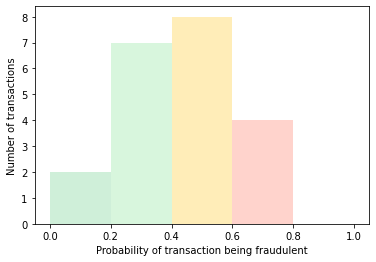

In [68]:
N, bins, patches = plt.hist(X_val['proba'], alpha=0.5, bins=5, range=(0,1))

for i in range(0,1):
    patches[i].set_facecolor('#A0E0B4')
for i in range(1,2):    
    patches[i].set_facecolor('#B3EFBC')
for i in range(2,3):
    patches[i].set_facecolor('#FFDC72')
for i in range(3,4):
    patches[i].set_facecolor('#FFA99B')
for i in range(4,5):
    patches[i].set_facecolor('#F88484')
    

plt.xlabel('Probability of transaction being fraudulent')
plt.ylabel('Number of transactions')
    
plt.show;

In [56]:
import pickle

# Export pipeline as pickle file
with open("pipeline_8.pkl", "wb") as file:
    pickle.dump(final_pipe, file)